<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/William_branch/Colour_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !make -C sparse_gaussian_elimination a.so

In [2]:
#@title Preamble
import os
import threading
import torch.multiprocessing as multiprocessing
import functools
import random
from math import log, sqrt, exp

import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from scipy.special import logsumexp, softmax, log_softmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import Adam, AdamW, SGD

from kfp import construct_A, construct_B, diffusion_coeff, marginal_prob_std, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, jacobi #  solve_pde
from network2 import Model

import PIL

np.random.seed(2)
torch.manual_seed(2)

#torch.set_default_device('cuda')

# create a.so if doesnt exists
# if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
#     os.system("make -C ../sparse_gaussian_elimination a.so")
cifar = CIFAR10('.', download=True)

Files already downloaded and verified


In [3]:
#@title Construct the grid and Initial values
batch_size = 1 #@param
N = 20 #@param
H = 32 #@param
W = 32 #@param
epoch = 80 #@param
eps = 1e-6 #@param
lr = 1e-3 #@param

channels = 3
dt = 1/N
sigma = 25 #@param
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [4]:
#@title Download mnist dataset
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
cifar_data = cifar.data[np.array(cifar.targets) == 5] # grab the fives

# sample 5 images for training
cifar_data = cifar_data[np.random.choice(list(range(len(cifar_data))), 3, replace=False)]

218 0


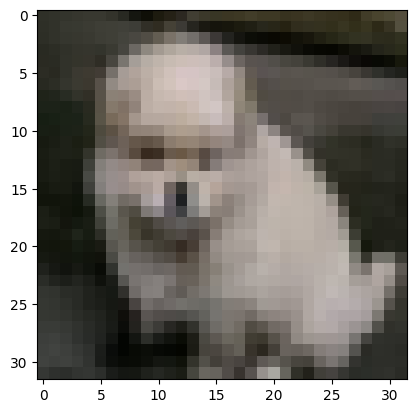

1.0 0.0


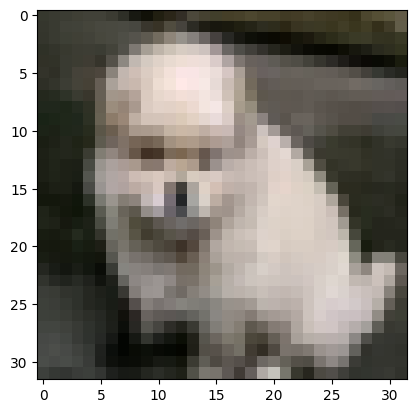

237 7


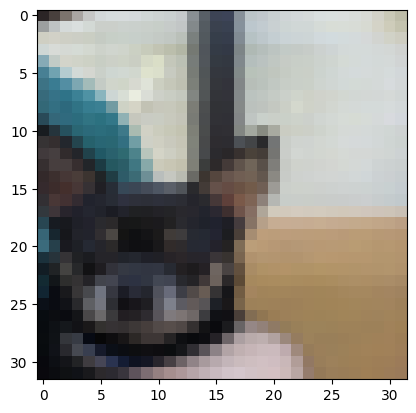

1.0 0.0


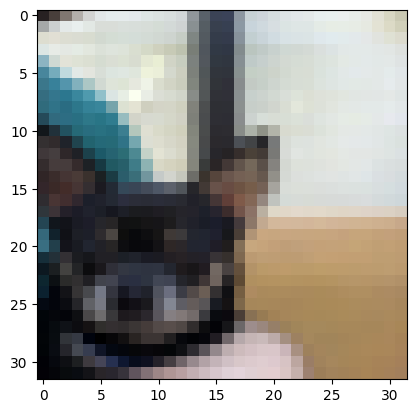

235 10


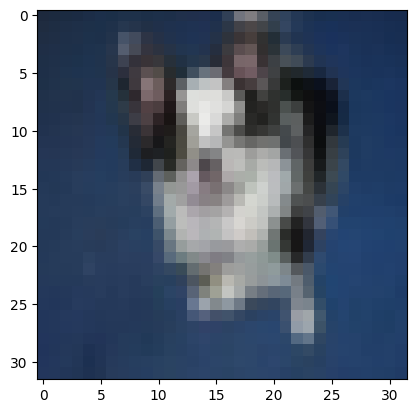

1.0 0.0


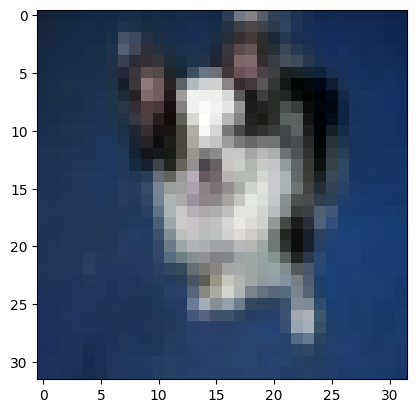

In [5]:
#@title Cropping the image
cropped_image_g = np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("L").crop((0, 0, 32, 32)))
cifar_data_list_grey = [torch.Tensor(cropped_image_g)]

cifar_data_list = []
cifar_data_list_tensor = []
for i in range(3):
  cropped_image_rgb = np.array(PIL.Image.fromarray(np.array(cifar_data[i])).convert("RGB").crop((0, 0, 32, 32)))
  cifar_data_list.append((cropped_image_rgb - cropped_image_rgb.min())/(cropped_image_rgb.max() - cropped_image_rgb.min())) # normalized to [0, 1]
  # cifar_data_list = [cropped_image_rgb]
  cifar_data_list_tensor.append(torch.Tensor(cifar_data_list[i].transpose((2, 0, 1))))

  print(cifar_data[i].max(), cifar_data[i].min())
  plt.imshow(cifar_data[i])
  plt.show()

  print(cifar_data_list[i].max(), cifar_data_list[i].min())
  plt.imshow((cifar_data_list[i] - cifar_data_list[i].min())/(cifar_data_list[i].max() - cifar_data_list[i].min()))
  plt.show()

In [6]:
#@title Defining pde diffusion per thread
# import cupy as cp
# from cupyx.scipy.sparse import csr_matrix as cp_csr
# from cupyx.scipy.sparse import linalg as cp_linalg

def diffuse(initial_m, m, dm, channel, time_, g, scores):

  m[0, channel] = initial_m[channel]
  dh = 1 # 256/(H*W)

  A_block = []
  for i in range(1, N):
    A = construct_A(H, W, dt/(2*dh), dt/(dh**2), 0, 0, g(time_[i]), scores[i, channel])#H,W,dh,dh2,f,g,s
    A_block.append(sparse.csr_matrix(A))

  A_block = sparse.block_diag(A_block, format='csr')
  A_block += sparse.diags(np.ones((N-1)*H*W)[H*W:], -H*W)
  B_block = np.zeros(((N-1)*H*W))
  B_block[:H*W] = construct_B(H, W, m[0, channel])

  pde_sol = sparse.linalg.spsolve(A_block, B_block) # cp.asnumpy(cp_linalg.spsolve(cp_csr(A_block), cp.array(B_block)))
  m[1:, channel] = pde_sol.reshape((-1, H*W))

  # del pde_sol
  # cp._default_memory_pool.free_all_blocks()

  img_log_prob = m[:, channel]
  dm[:, channel, 1:-1] = (img_log_prob[:, 2:] - img_log_prob[:, :-2])/(2*dh) # (img_log_prob[:, 1:-1, 2:] - img_log_prob[:, 1:-1, :-2])/(2*dy)
  dm[:, channel, 0] = (img_log_prob[:, 1] - 0)/(2*dh) #+ (img_log_prob[:, 1:-1, 0] - img_log_prob[:, 1:-1, -1])/dy
  dm[:, channel, -1] = (0 - img_log_prob[:, -2])/(2*dh) #+ (img_log_prob[:, 1:-1, -1] - img_log_prob[:, 1:-1, 0])/dy
  # dm[:, channel, 0 , 1:-1] = (img_log_prob[:, 0, 2:] - img_log_prob[:, 0, :-2])/(2*dy) + (img_log_prob[:, 0, 1:-1] - img_log_prob[:, -1, 1:-1])/dx
  # dm[:, channel, -1 , 1:-1] = (img_log_prob[:, -1, 2:] - img_log_prob[:, -1, :-2])/(2*dy) + (img_log_prob[:, -1, 1:-1] - img_log_prob[:, 0, 1:-1])/dx

In [7]:
#@title Precompute score labels by solving the PDE
tol = 1e-3 #@param
max_iter = 1000 #@param

if not os.path.exists('scores_label'):
  scores_label = []
  init_m_batch = []
  for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
    y_train = []
    for j in range(H):
      y_train.append(data[:, j, :])
    y_train = np.concatenate(y_train, axis=-1)

    x_train = []
    for l in range(W):
      x_train.append(data[:, :, l])
    x_train = np.concatenate(x_train, axis=1)

    init_m = []
    for ch in range(channels):
      xy_train = np.vstack([x_train[ch], y_train[ch]])
      kde_kernel = stats.gaussian_kde(xy_train)
      init_m.append(kde_kernel.logpdf(xy_train)[None])

    init_m = np.concatenate(init_m)
    init_m_batch.append(init_m[None])
  init_m_batch = np.concatenate(init_m_batch)

  for idx, data in enumerate(cifar_data_list_tensor):

    m = np.zeros((N, channels, H*W), dtype=np.float32)
    m_prev = np.zeros((N, channels, H*W), dtype=np.float32)
    scores = np.zeros((N, channels, H*W), dtype=np.float32) # initial scores guess
    dm = np.zeros_like(scores, dtype=np.float32)

    res = 1
    e = 0
    while res > tol:
      res_prev = res
      # we want to sample from random time steps to construct training samples
      time_ = np.linspace(eps, 1., N) + idx
      print(time_.max(), time_.min())
      # diffuse all three channels concurrently
      for ch in tqdm(range(channels)):
        diffuse(init_m_batch[idx], m, dm, ch, time_, diffusion_coeff_fn, scores)

      scores = dm.copy()

      if e == max_iter:
        print(f'No convergence')
        break

      res = np.linalg.norm(m - m_prev)
      print(f'residual at iteration {e}: {res}')

      m_prev = m.copy()
      e += 1

      if abs(res_prev - res) < 1e-6:
        break

    scores_label.append(scores.copy().reshape((1, -1, channels, H, W)))
  scores_label = np.concatenate(scores_label) + eps
  print(scores_label.shape)

0.74895227 0.18986504


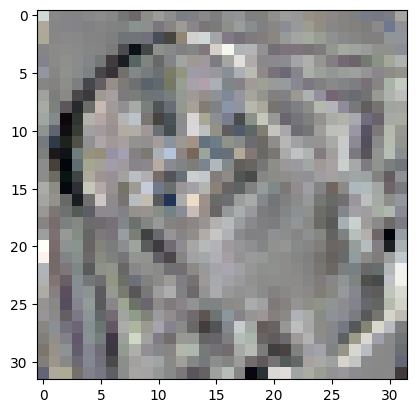

0.49093726 0.49093726


<ipython-input-8-cc08e3764446>:12: RuntimeWarning: invalid value encountered in divide
  plt.imshow(((scores_label[idx][-1] - scores_label[idx][-1].min())/(scores_label[idx][-1].max() - scores_label[idx][-1].min())).transpose(1, 2, 0))
/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


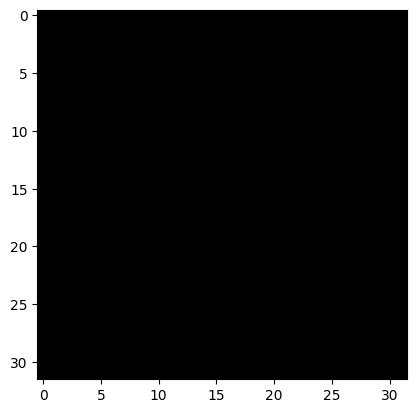

0.7119141 0.24196766


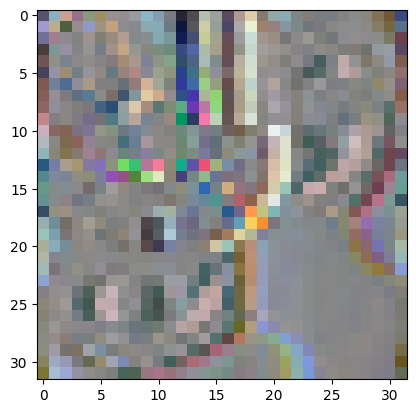

0.49093726 0.49093726


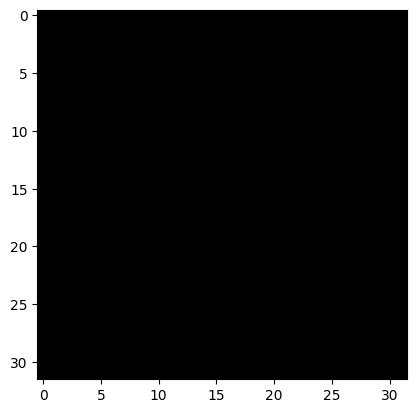

1.0 0.0


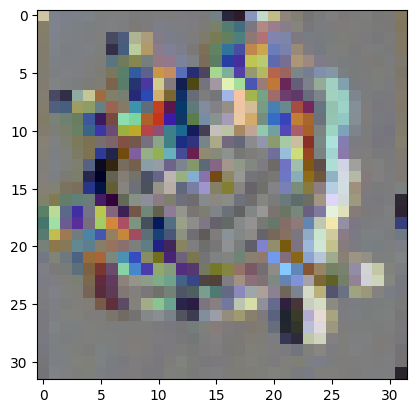

0.49093726 0.49093726


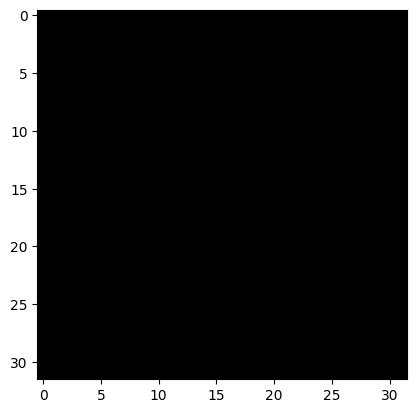

In [8]:
#@title Show the score labels
import pickle
if os.path.exists(f'scores_label'):
  with open('/content/scores_label', 'rb') as file:
    scores_label = pickle.load(file)

for idx in range(3):
  print(scores_label[idx][0].max(), scores_label[idx][0].min())
  plt.imshow(((scores_label[idx][0] - scores_label[idx][0].min())/(scores_label[idx][0].max() - scores_label[idx][0].min())).transpose(1, 2, 0))
  plt.show()
  print(scores_label[idx][-1].max(), scores_label[idx][-1].min())
  plt.imshow(((scores_label[idx][-1] - scores_label[idx][-1].min())/(scores_label[idx][-1].max() - scores_label[idx][-1].min())).transpose(1, 2, 0))
  plt.show()

In [9]:
import pickle
if not os.path.exists('scores_label'):
  with open('/content/scores_label', 'wb') as file:
    pickle.dump((scores_label - scores_label.min()) / (scores_label.max() - scores_label.min()), file)

In [10]:
#@title Denoising network training
def loss_fn(model, x, label, diffusion_coeff, marginal_prob_std, idx=1, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.tensor(np.sort(np.random.uniform(eps, 1., N)).astype(np.float32)) + idx
  # we encode the label into the initial data using the reverse ODE
  diff_std2 = diffusion_coeff(2 * random_t)
  for i in range(1, N):
    x[i] = x[i-1] - 0.5 * ((label[i-1] + label[i])/2) * diff_std2[i-1] * dt
  std = marginal_prob_std(random_t)
  z = torch.randn_like(x)
  # we perturb the image by the forward SDE conditional distribution
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  # loss = torch.mean((diff_std2) * torch.sum((score * std[:, None, None, None] - label)**2, dim=(1, 2, 3)) / (2 * diff_std2))
  loss = torch.mean(torch.sum((score + z / std[:, None, None, None])**2, dim=(1, 2, 3))) # original loss from tutorial
  return loss

In [11]:
#@title Function for training on a thread
def diffuse_train(init_x, epoch, diffusion_coeff, marginal_prob_std, label, losses, model_score, optimizer, idx=1):
  scores_label = torch.tensor(label)

  loss = loss_fn(model_score, init_x, scores_label, diffusion_coeff, marginal_prob_std, idx)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  losses.append(loss)

In [12]:
#@title Training the score-network
if os.path.exists(f'model_cifar.pth'):
  print(f'removing saved weights\n')
  os.remove(f'model_cifar.pth')

init_x = torch.zeros((N, channels, H, W))

model_score = Model()
optimizer = AdamW(model_score.parameters(), lr=lr)
model_score.train();

for e in tqdm(range(epoch)):
  losses = []
  for idx, data in enumerate(cifar_data_list_tensor):

    for i in range(N):
      init_x[i] = data

    diffuse_train(init_x, epoch, diffusion_coeff_fn, marginal_prob_std_fn, scores_label[idx], losses, model_score, optimizer, idx)

    print(f'\nloss: {losses[idx]}')

file = f'model_cifar.pth'
torch.save(model_score.state_dict(), file)
print(f"model has been saved\n")

  0%|          | 0/80 [00:00<?, ?it/s]


loss: 4134.73974609375

loss: 189.156005859375


  1%|▏         | 1/80 [00:23<30:21, 23.06s/it]


loss: 90.98554229736328

loss: 10526.255859375

loss: 88.49688720703125


  2%|▎         | 2/80 [00:35<21:44, 16.72s/it]


loss: 45.13292694091797

loss: 2301.148193359375

loss: 76.06710052490234


  4%|▍         | 3/80 [00:47<18:50, 14.68s/it]


loss: 50.151893615722656

loss: 76227.2265625

loss: 55.858192443847656


  5%|▌         | 4/80 [00:59<17:25, 13.76s/it]


loss: 26.04327964782715

loss: 15738.3720703125

loss: 66.12503051757812


  6%|▋         | 5/80 [01:11<16:25, 13.14s/it]


loss: 33.93644714355469

loss: 63730.44921875

loss: 57.74379348754883


  8%|▊         | 6/80 [01:23<15:38, 12.68s/it]


loss: 28.92584800720215

loss: 17575.0625

loss: 55.9315071105957


  9%|▉         | 7/80 [01:35<15:03, 12.37s/it]


loss: 34.6339111328125

loss: 2539.342041015625

loss: 59.239662170410156


 10%|█         | 8/80 [01:50<15:42, 13.09s/it]


loss: 27.695907592773438

loss: 20058.048828125

loss: 47.66277313232422


 11%|█▏        | 9/80 [02:01<14:59, 12.67s/it]


loss: 27.322635650634766

loss: 3942.121826171875

loss: 54.097450256347656


 12%|█▎        | 10/80 [02:13<14:30, 12.44s/it]


loss: 24.792903900146484

loss: 1451.9779052734375

loss: 49.32490158081055


 14%|█▍        | 11/80 [02:26<14:15, 12.40s/it]


loss: 22.071453094482422

loss: 8427.6083984375

loss: 33.07659912109375


 15%|█▌        | 12/80 [02:38<13:58, 12.33s/it]


loss: 21.369110107421875

loss: 4745.001953125

loss: 35.250755310058594


 16%|█▋        | 13/80 [02:50<13:45, 12.32s/it]


loss: 19.9600887298584

loss: 393.03851318359375

loss: 34.94066619873047


 18%|█▊        | 14/80 [03:02<13:32, 12.31s/it]


loss: 18.678590774536133

loss: 359.7584533691406

loss: 34.25233840942383


 19%|█▉        | 15/80 [03:14<13:16, 12.26s/it]


loss: 17.635854721069336

loss: 15696.900390625

loss: 39.44615173339844


 20%|██        | 16/80 [03:27<13:02, 12.22s/it]


loss: 20.00389289855957

loss: 12966.736328125

loss: 39.84527587890625


 21%|██▏       | 17/80 [03:39<12:48, 12.20s/it]


loss: 19.904338836669922

loss: 6371.7236328125

loss: 47.60113525390625


 22%|██▎       | 18/80 [03:51<12:36, 12.20s/it]


loss: 17.62322998046875

loss: 4330.82373046875

loss: 49.339412689208984


 24%|██▍       | 19/80 [04:03<12:26, 12.24s/it]


loss: 19.15312957763672

loss: 1147.78369140625

loss: 32.10022735595703


 25%|██▌       | 20/80 [04:16<12:14, 12.25s/it]


loss: 16.24170684814453

loss: 937.5618896484375

loss: 33.92908477783203


 26%|██▋       | 21/80 [04:28<12:00, 12.22s/it]


loss: 17.68280792236328

loss: 4356.5126953125

loss: 30.745494842529297


 28%|██▊       | 22/80 [04:40<11:46, 12.19s/it]


loss: 16.150197982788086

loss: 1719.189697265625

loss: 32.01935577392578


 29%|██▉       | 23/80 [04:52<11:35, 12.20s/it]


loss: 17.732086181640625

loss: 4822.3642578125

loss: 29.991878509521484


 30%|███       | 24/80 [05:04<11:25, 12.25s/it]


loss: 16.29446029663086

loss: 10371.0927734375

loss: 25.579322814941406


 31%|███▏      | 25/80 [05:17<11:16, 12.30s/it]


loss: 15.851327896118164

loss: 1076.053955078125

loss: 26.20464515686035


 32%|███▎      | 26/80 [05:29<11:05, 12.33s/it]


loss: 19.290855407714844

loss: 3679.826904296875

loss: 26.645259857177734


 34%|███▍      | 27/80 [05:41<10:50, 12.28s/it]


loss: 14.304760932922363

loss: 12673.2978515625

loss: 36.272544860839844


 35%|███▌      | 28/80 [05:54<10:37, 12.26s/it]


loss: 20.391637802124023

loss: 1250.877685546875

loss: 31.999576568603516


 36%|███▋      | 29/80 [06:05<10:15, 12.07s/it]


loss: 22.4735164642334

loss: 10423.5048828125

loss: 34.26987075805664


 38%|███▊      | 30/80 [06:17<10:04, 12.09s/it]


loss: 16.995832443237305

loss: 7188.16015625

loss: 35.85978317260742


 39%|███▉      | 31/80 [06:29<09:52, 12.09s/it]


loss: 14.698453903198242

loss: 2117.0400390625

loss: 28.20047950744629


 40%|████      | 32/80 [06:42<09:41, 12.12s/it]


loss: 21.420852661132812

loss: 9692.361328125

loss: 26.265335083007812


 41%|████▏     | 33/80 [06:54<09:33, 12.19s/it]


loss: 16.522733688354492

loss: 4147.3876953125

loss: 35.081729888916016


 42%|████▎     | 34/80 [07:06<09:23, 12.24s/it]


loss: 16.7408390045166

loss: 2401.177978515625

loss: 32.66534423828125


 44%|████▍     | 35/80 [07:19<09:11, 12.26s/it]


loss: 18.378238677978516

loss: 698.1630249023438

loss: 28.768985748291016


 45%|████▌     | 36/80 [07:31<08:59, 12.27s/it]


loss: 15.995559692382812

loss: 2409.791259765625

loss: 31.978649139404297


 46%|████▋     | 37/80 [07:43<08:46, 12.25s/it]


loss: 16.42452049255371

loss: 1794.2958984375

loss: 28.544530868530273


 48%|████▊     | 38/80 [07:55<08:34, 12.25s/it]


loss: 16.256494522094727

loss: 730.790283203125

loss: 23.642902374267578


 49%|████▉     | 39/80 [08:08<08:24, 12.30s/it]


loss: 15.583738327026367

loss: 7594.8173828125

loss: 24.31539535522461


 50%|█████     | 40/80 [08:20<08:12, 12.31s/it]


loss: 16.673572540283203

loss: 1995.1754150390625

loss: 26.554351806640625


 51%|█████▏    | 41/80 [08:32<07:59, 12.30s/it]


loss: 18.133346557617188

loss: 2271.45263671875

loss: 28.469717025756836


 52%|█████▎    | 42/80 [08:45<07:46, 12.27s/it]


loss: 19.16366958618164

loss: 14855.7705078125

loss: 35.58915328979492


 54%|█████▍    | 43/80 [08:57<07:33, 12.25s/it]


loss: 16.980913162231445

loss: 2564.77783203125

loss: 34.079166412353516


 55%|█████▌    | 44/80 [09:09<07:21, 12.25s/it]


loss: 18.580961227416992

loss: 508.7882385253906

loss: 34.07317352294922


 56%|█████▋    | 45/80 [09:21<07:09, 12.28s/it]


loss: 18.251178741455078

loss: 44646.32421875

loss: 34.020957946777344


 57%|█████▊    | 46/80 [09:34<06:59, 12.33s/it]


loss: 16.99386215209961

loss: 1649.105712890625

loss: 33.770103454589844


 59%|█████▉    | 47/80 [09:46<06:44, 12.26s/it]


loss: 16.12103843688965

loss: 1925.2412109375

loss: 44.864688873291016


 60%|██████    | 48/80 [09:58<06:28, 12.14s/it]


loss: 17.49184226989746

loss: 461505.1875

loss: 33.33613967895508


 61%|██████▏   | 49/80 [10:10<06:15, 12.11s/it]


loss: 25.88857650756836

loss: 810.9002685546875

loss: 33.707862854003906


 62%|██████▎   | 50/80 [10:22<06:04, 12.15s/it]


loss: 24.741392135620117

loss: 89578.203125

loss: 27.419490814208984


 64%|██████▍   | 51/80 [10:34<05:53, 12.19s/it]


loss: 25.318923950195312

loss: 1732.586669921875

loss: 35.35105514526367


 65%|██████▌   | 52/80 [10:47<05:41, 12.20s/it]


loss: 23.40805435180664

loss: 22604.13671875

loss: 28.907745361328125


 66%|██████▋   | 53/80 [10:59<05:31, 12.26s/it]


loss: 26.64430809020996

loss: 3421.453125

loss: 38.71513366699219


 68%|██████▊   | 54/80 [11:11<05:19, 12.27s/it]


loss: 21.15403938293457

loss: 2489.12109375

loss: 30.28908348083496


 69%|██████▉   | 55/80 [11:24<05:07, 12.28s/it]


loss: 21.373268127441406

loss: 708.8099975585938

loss: 26.331523895263672


 70%|███████   | 56/80 [11:36<04:55, 12.33s/it]


loss: 21.808494567871094

loss: 4321.9404296875

loss: 33.33039474487305


 71%|███████▏  | 57/80 [11:48<04:42, 12.28s/it]


loss: 19.73668670654297

loss: 76445.453125

loss: 37.559410095214844


 72%|███████▎  | 58/80 [12:01<04:29, 12.27s/it]


loss: 24.624420166015625

loss: 272354.71875

loss: 48.4527587890625


 74%|███████▍  | 59/80 [12:13<04:18, 12.30s/it]


loss: 25.30625343322754

loss: 42358.7890625

loss: 52.59147262573242


 75%|███████▌  | 60/80 [12:25<04:05, 12.28s/it]


loss: 27.728870391845703

loss: 4775.693359375

loss: 63.23450469970703


 76%|███████▋  | 61/80 [12:37<03:52, 12.25s/it]


loss: 39.049232482910156

loss: 2120.333740234375

loss: 51.6294059753418


 78%|███████▊  | 62/80 [12:50<03:40, 12.23s/it]


loss: 32.6501579284668

loss: 747.2291259765625

loss: 109.36360931396484


 79%|███████▉  | 63/80 [13:03<03:35, 12.68s/it]


loss: 55.41217803955078

loss: 7760.12646484375

loss: 79.0453872680664


 80%|████████  | 64/80 [13:16<03:23, 12.70s/it]


loss: 54.749961853027344

loss: 2024.778564453125

loss: 150.53488159179688


 81%|████████▏ | 65/80 [13:29<03:11, 12.79s/it]


loss: 311.8626403808594

loss: 2283.402587890625

loss: 363.06781005859375


 82%|████████▎ | 66/80 [13:42<02:58, 12.74s/it]


loss: 193.47000122070312

loss: 2219.79541015625

loss: 143.39959716796875


 84%|████████▍ | 67/80 [13:55<02:48, 12.99s/it]


loss: 131.12045288085938

loss: 5392.1416015625

loss: 267.45751953125


 85%|████████▌ | 68/80 [14:09<02:38, 13.18s/it]


loss: 138.91156005859375

loss: 5783.4052734375

loss: 133.8572540283203


 86%|████████▋ | 69/80 [14:22<02:26, 13.29s/it]


loss: 183.62252807617188

loss: 401.481689453125

loss: 167.5792694091797


 88%|████████▊ | 70/80 [14:36<02:13, 13.36s/it]


loss: 79.45746612548828

loss: 2689.321044921875

loss: 87.93963623046875


 89%|████████▉ | 71/80 [14:49<01:59, 13.24s/it]


loss: 55.598388671875

loss: 5054.88720703125

loss: 86.03229522705078


 90%|█████████ | 72/80 [15:02<01:44, 13.12s/it]


loss: 70.77806091308594

loss: 1566.4530029296875

loss: 108.01594543457031


 91%|█████████▏| 73/80 [15:15<01:31, 13.14s/it]


loss: 72.75418090820312

loss: 2133.67041015625

loss: 275.5473327636719


 92%|█████████▎| 74/80 [15:27<01:17, 12.92s/it]


loss: 212.9061279296875

loss: 113004.7890625

loss: 123.68797302246094


 94%|█████████▍| 75/80 [15:41<01:05, 13.10s/it]


loss: 126.14632415771484

loss: 19751.9140625

loss: 95.3624038696289


 95%|█████████▌| 76/80 [15:54<00:52, 13.04s/it]


loss: 59.08582305908203

loss: 51610.8046875

loss: 180.0035858154297


 96%|█████████▋| 77/80 [16:07<00:39, 13.16s/it]


loss: 238.93576049804688

loss: 4485.576171875

loss: 170.15512084960938


 98%|█████████▊| 78/80 [16:20<00:26, 13.03s/it]


loss: 591.1828002929688

loss: 12063.2939453125

loss: 102.0723876953125


 99%|█████████▉| 79/80 [16:33<00:13, 13.05s/it]


loss: 173.87451171875

loss: 4392.2509765625

loss: 123.64208984375


100%|██████████| 80/80 [16:47<00:00, 12.59s/it]


loss: 71.84737396240234
model has been saved



In [13]:
#@title Define the ODE sampler (double click to expand or collapse)
from scipy import integrate
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-4 #@param
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3,
                idx = 1):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device) + idx
  # Create the latent code
  if z is None:
    initial_x = torch.randn(batch_size, channels, H, W, device=device) #* marginal_prob_std(t)[:, None, None, None]
  else:
    initial_x = z + torch.randn(batch_size, channels, H, W, device=device) #* marginal_prob_std(t)[:, None, None, None]

  shape = initial_x.shape
  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t + idx
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), initial_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')

  print(f"\nNumber of function evaluations: {res.nfev}")
  x = []
  for i in range(res.y.shape[-1]):
    x.append(res.y[:, i].reshape(shape))
  x = np.concatenate(x, axis = 0)
  return x

In [14]:
#@title Function for threading ODE sampler
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# function for sampling on a thread
def diffuse_sample(data_x, samples, diffusion_coeff, marginal_prob_std, model, idx=1):

  sample_batch_size = batch_size
  sampler = ode_sampler

  # Generate samples using the specified sampler.
  output = sampler(model_score,
                  marginal_prob_std,
                  diffusion_coeff,
                  sample_batch_size,
                  idx = idx)

  samples.append(output)

0it [00:00, ?it/s]


Number of function evaluations: 206
(-0.02167667664724604, 1.0110664767939948)


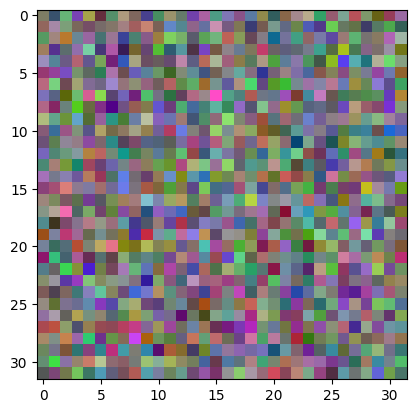

(-0.03149219342363311, 0.6897286651588199)


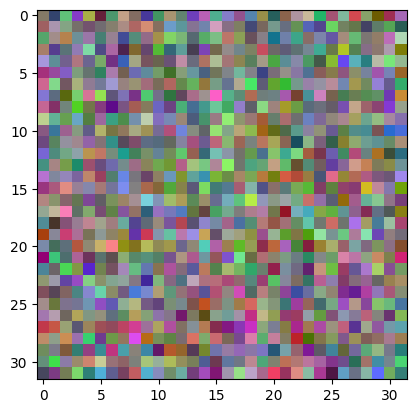

(-0.041727676623587194, 0.49438375311552163)


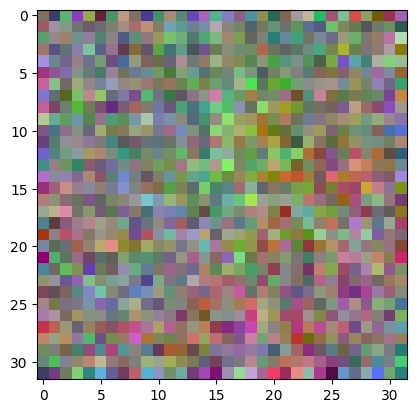

(-0.051020034864099985, 0.3912725178768943)


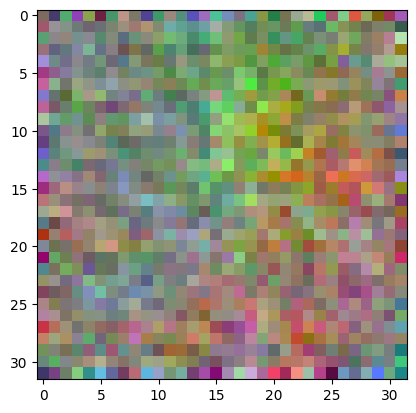

(-0.05961305093649751, 0.3507534890645573)


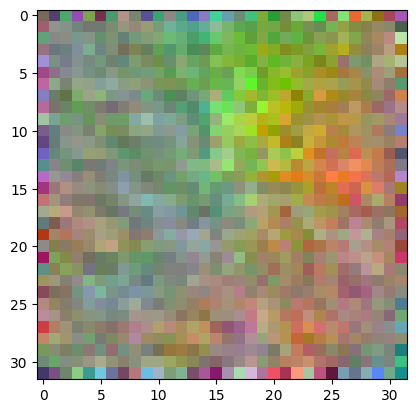

(-0.06698518201259876, 0.3557032089209811)


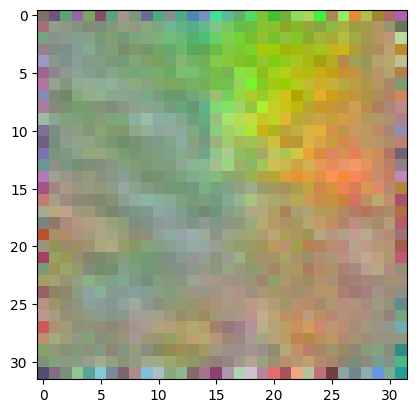

(-0.07335281809786143, 0.3861597650948067)


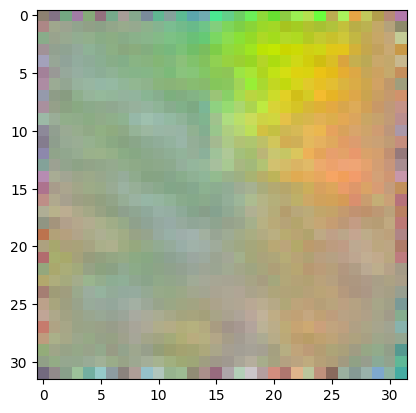

(-0.07883298924623529, 0.43329234469052297)


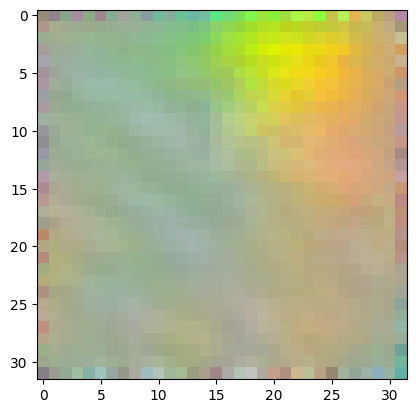

(-0.084457367923499, 0.49496559273336527)


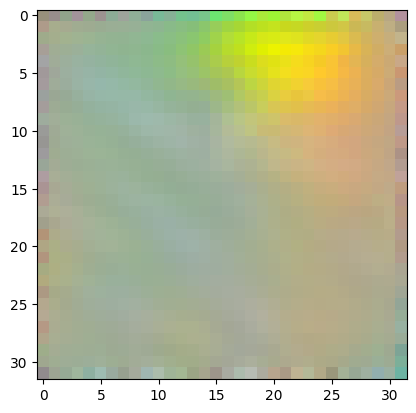

(-0.09239770595170027, 0.5838559782535985)


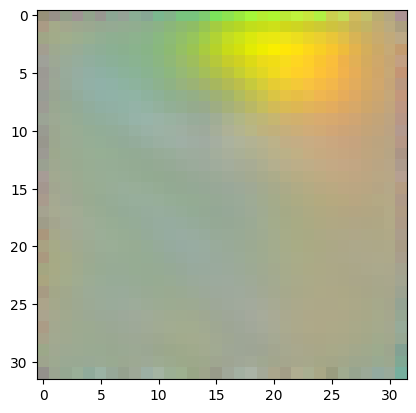

(-0.10411878100857865, 0.7011081023972281)


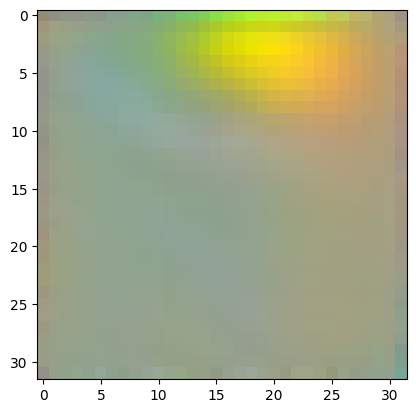

(-0.12134764070127774, 0.8445720622869572)


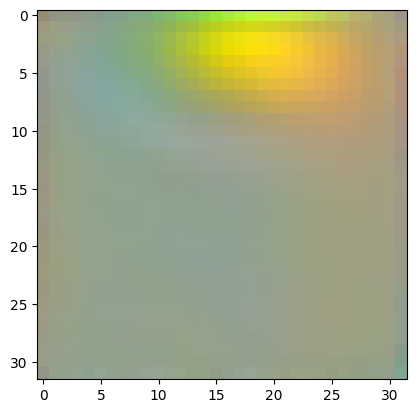

(-0.14473571567571286, 1.003318287432101)


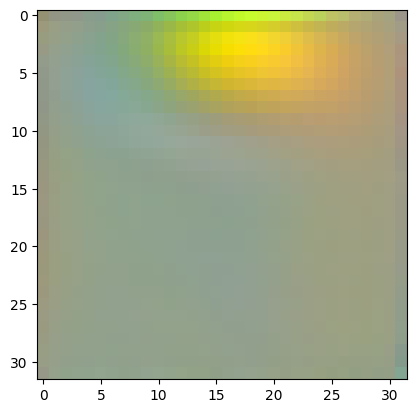

(-0.1752131314369727, 1.1742930665547144)


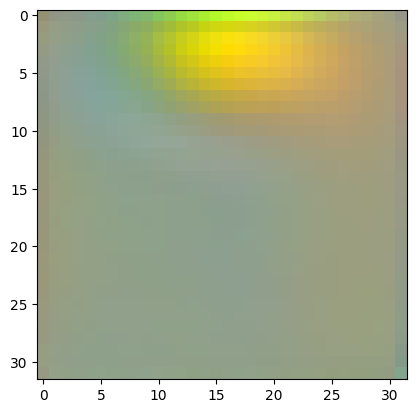

(-0.2145861219127526, 1.3609339648697982)


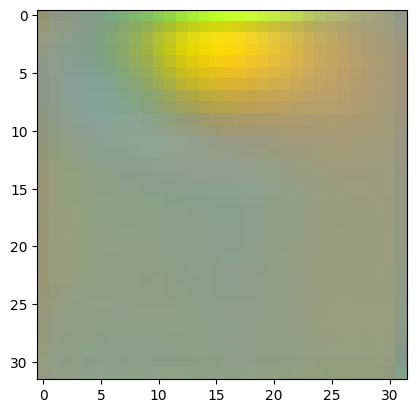

(-0.26426538132700544, 1.564496620261763)


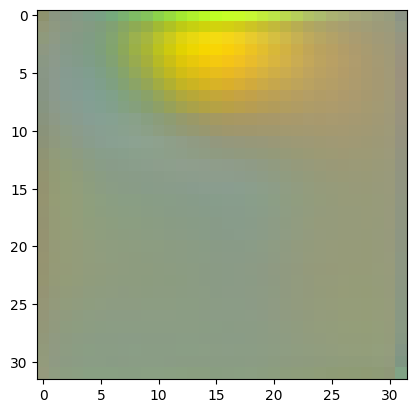

(-0.3248209359003873, 1.7846451189972892)


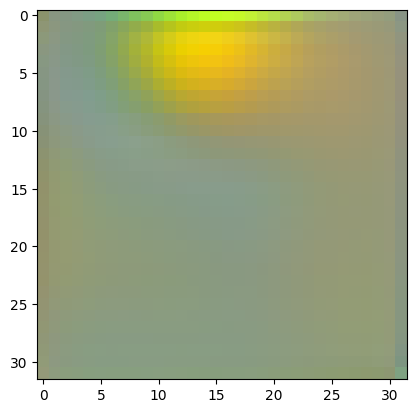

(-0.39691931294803035, 2.0259861581481653)


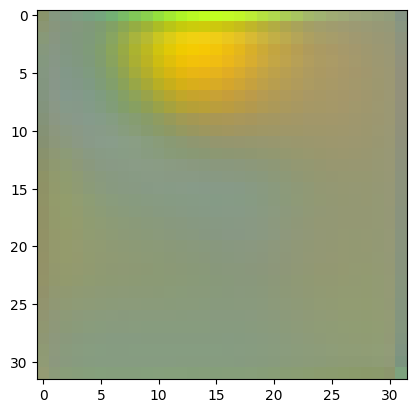

(-0.4815362385351189, 2.3015577784231827)


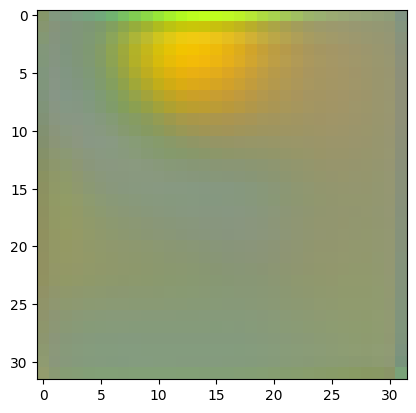

(-0.5780164759246625, 2.6332027672675755)


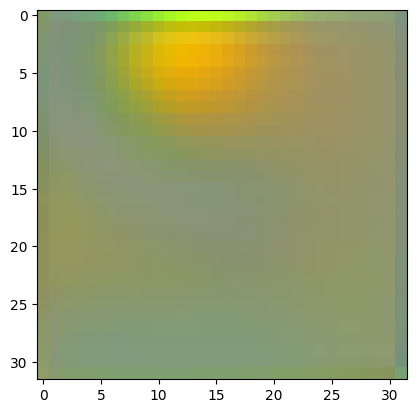

(-0.677689762837277, 3.0518433880584115)


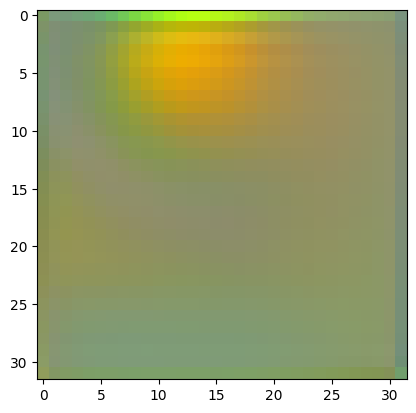

(-0.7524582567111925, 3.60530927365787)


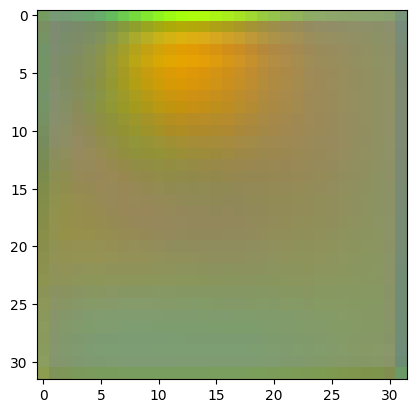

(-0.7681358306657815, 4.320213151145347)


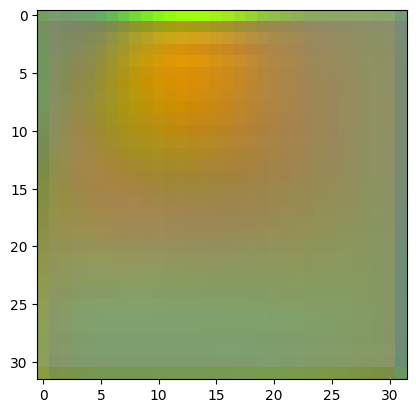

(-0.7472303987914386, 4.93925323641779)


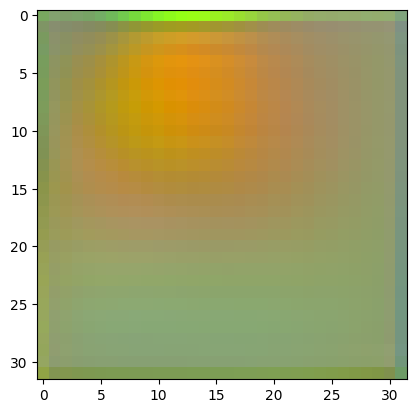

(-0.7072686334524491, 5.622942329117111)


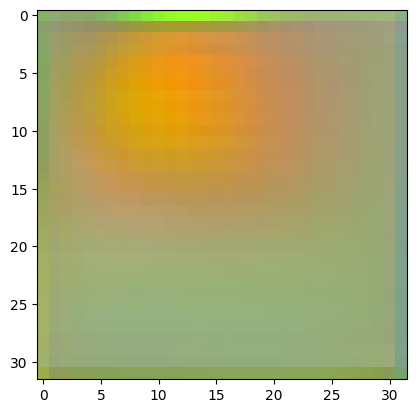

(-0.6561335083777798, 6.327924910688848)


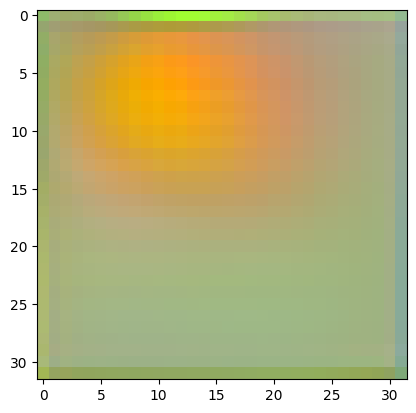

(-0.608990201569871, 6.977330603020346)


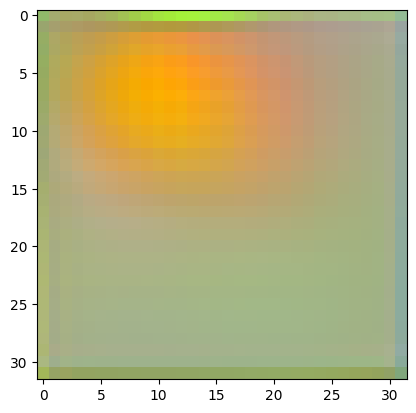

(-0.5698294131608174, 7.604364901737237)


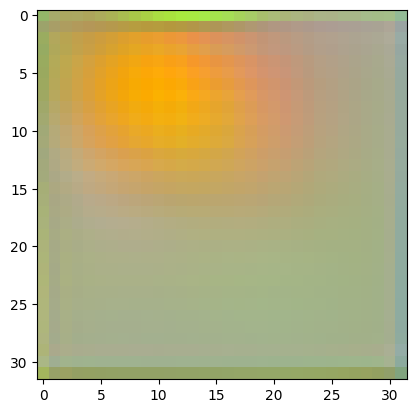

(-0.5421796213939011, 8.222008246758476)


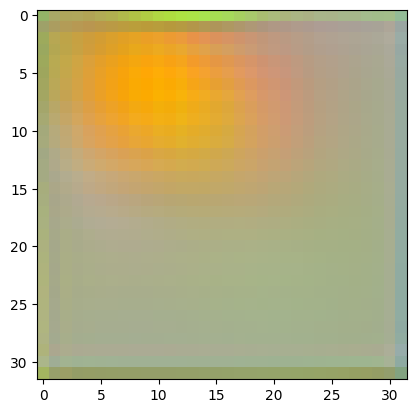

(-0.5298481249292942, 8.76921865085719)


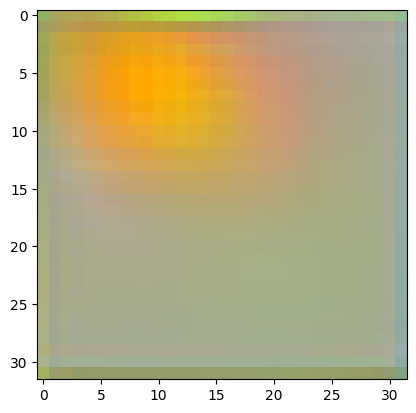

(-0.530501128340811, 9.067107857603059)


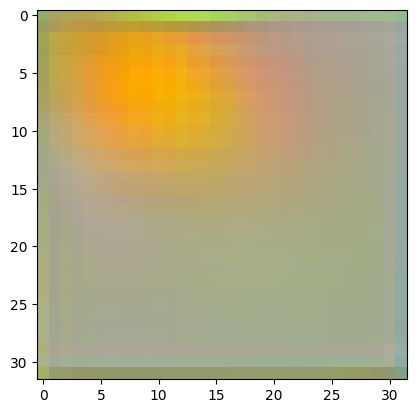

(-0.5331291091472057, 9.144731585210078)


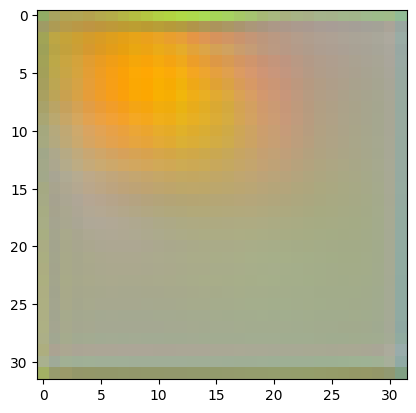

1it [00:35, 35.71s/it]


Number of function evaluations: 200
(-0.001466727471192068, 0.9973546833985971)


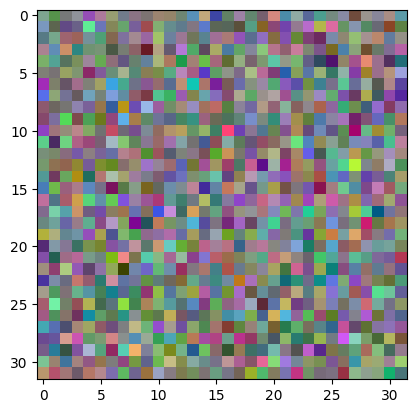

(-0.01171410144067709, 0.6815456554761389)


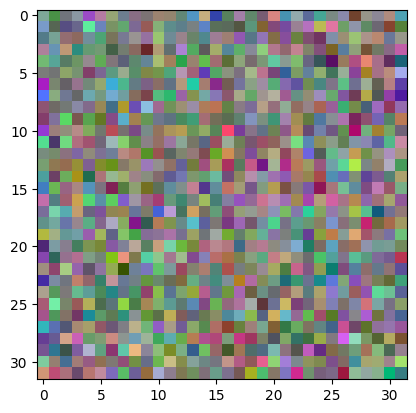

(-0.021506207602025585, 0.4707380460663801)


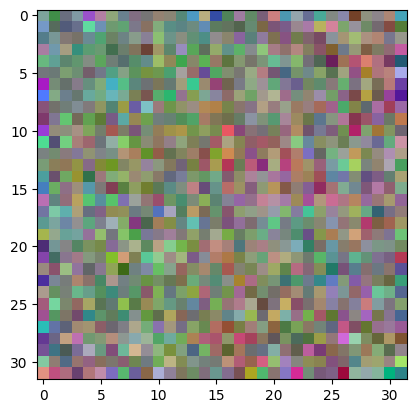

(-0.03019448593920369, 0.3569694434543974)


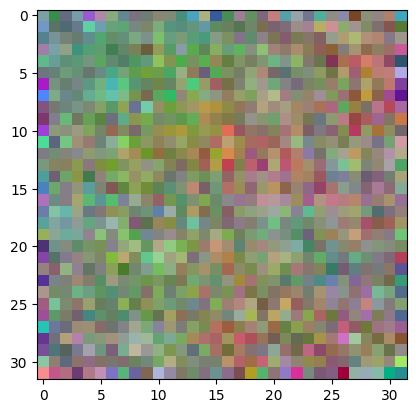

(-0.03939315683949934, 0.3031455500732847)


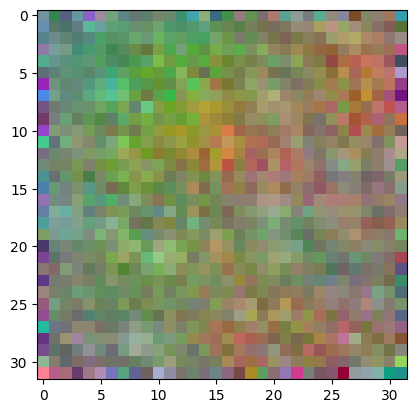

(-0.048402276489116214, 0.29567218038066234)


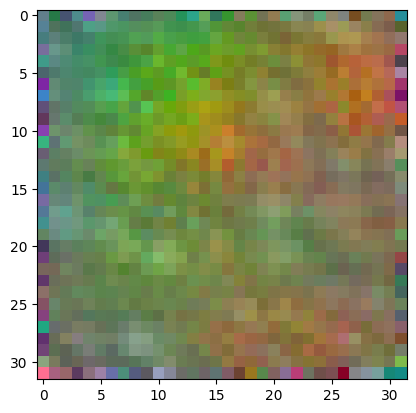

(-0.057788971656812765, 0.31246711963029805)


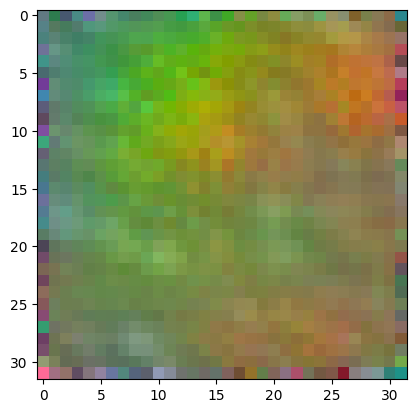

(-0.06831737774441755, 0.3473749932590526)


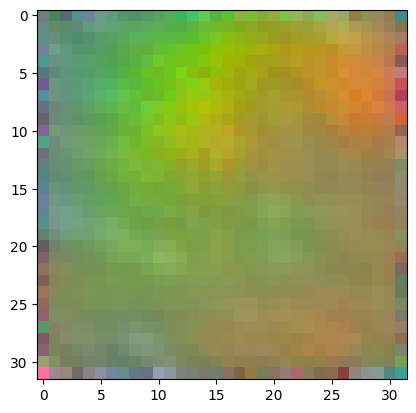

(-0.08078398124578727, 0.40126101850213536)


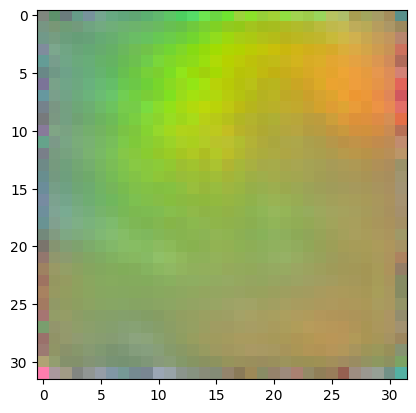

(-0.09584967020310231, 0.475195479880194)


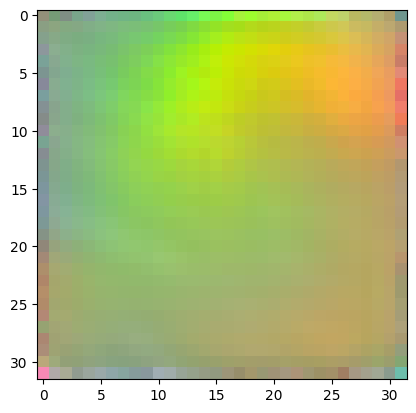

(-0.11484141362666261, 0.5732693269906529)


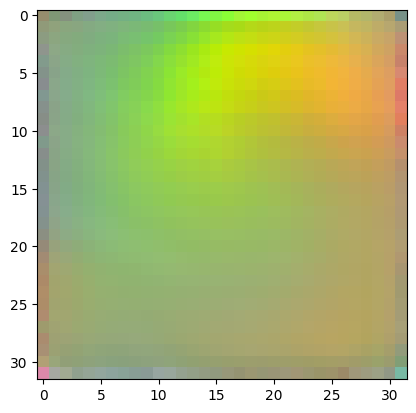

(-0.13926320812390144, 0.7001970483438038)


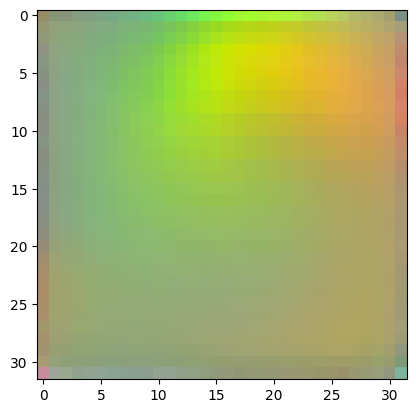

(-0.17598251696591685, 0.886335741915817)


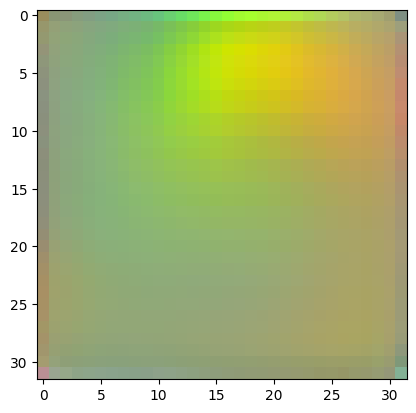

(-0.21636109650407956, 1.0810790925676705)


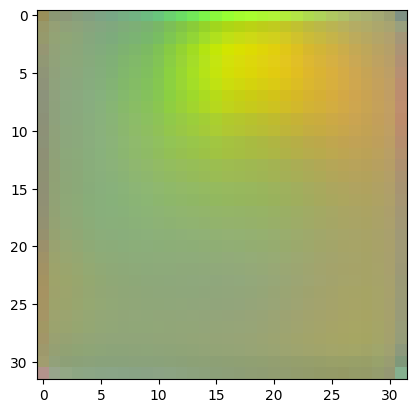

(-0.2610608675864187, 1.2832507662066885)


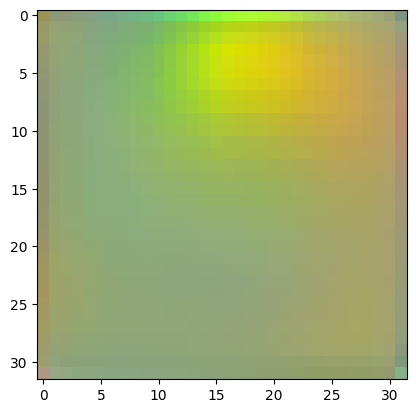

(-0.31213667332858, 1.4988485470379511)


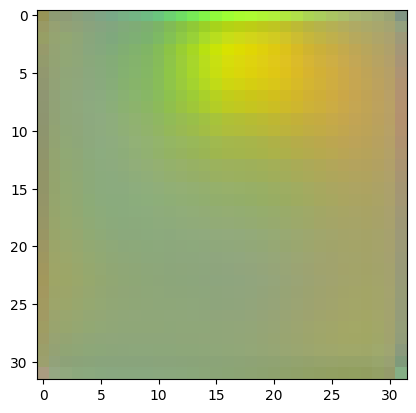

(-0.37228732364930733, 1.7383256491260546)


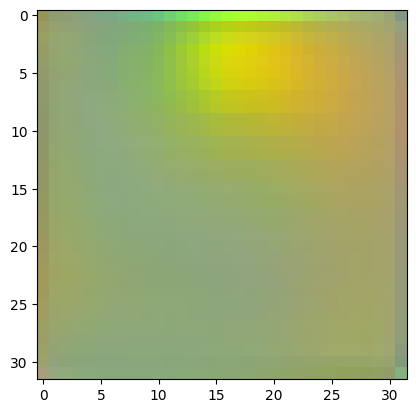

(-0.44537135014825835, 2.0206338521446394)


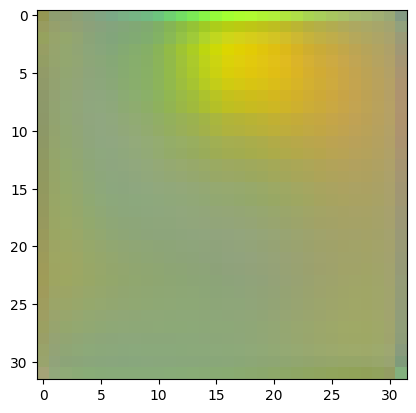

(-0.53321920074384, 2.3660820650848935)


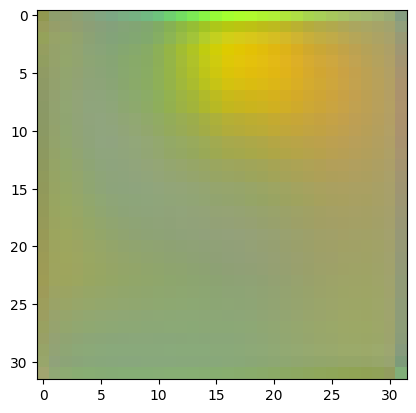

(-0.6324142647710601, 2.7949123716989166)


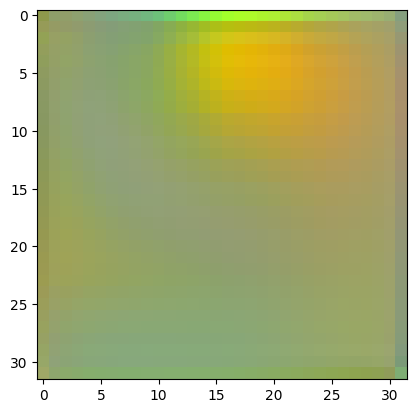

(-0.7303243683358337, 3.33364308495227)


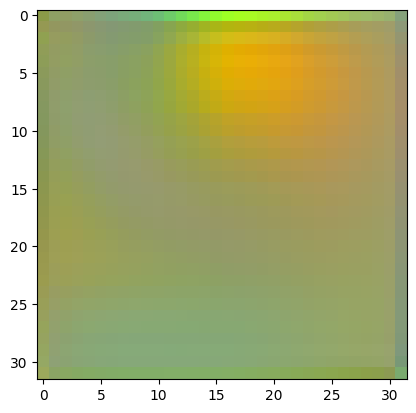

(-0.7988973487834299, 4.006882485660976)


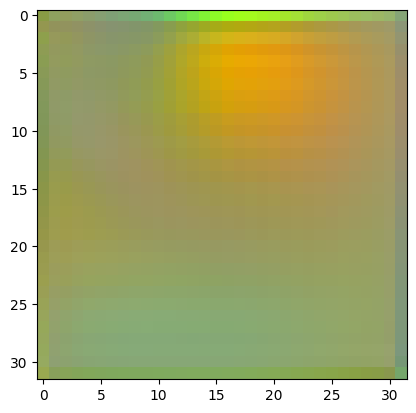

(-0.8104768181550165, 4.763780708806194)


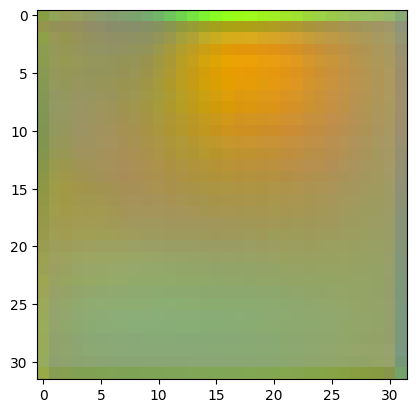

(-0.7819841126486589, 5.406235556317834)


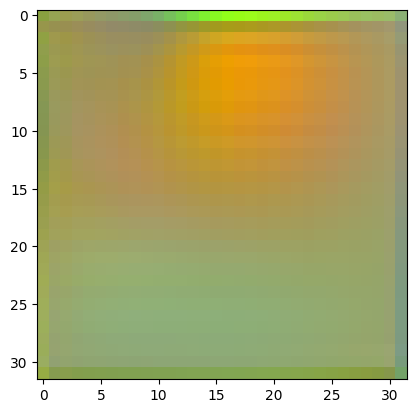

(-0.7290742341475998, 6.0716016100059855)


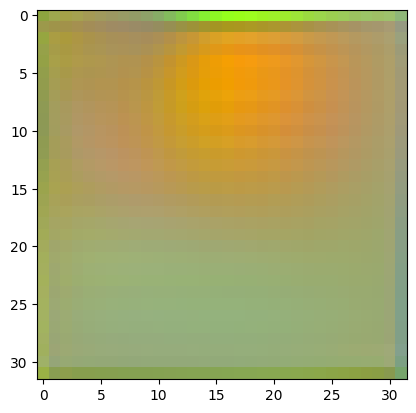

(-0.6662619253277816, 6.739326798928759)


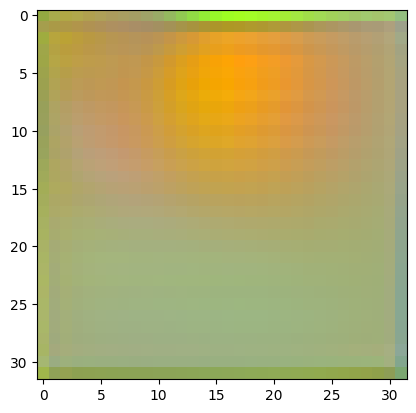

(-0.6137842444022459, 7.321919878782424)


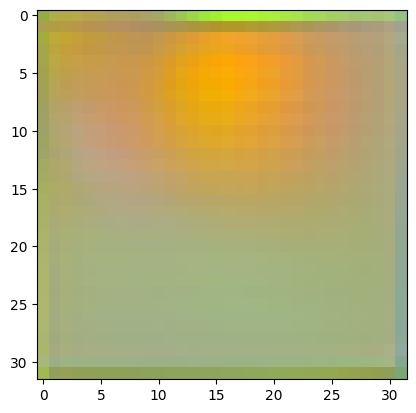

(-0.5708457133143335, 7.87674908342094)


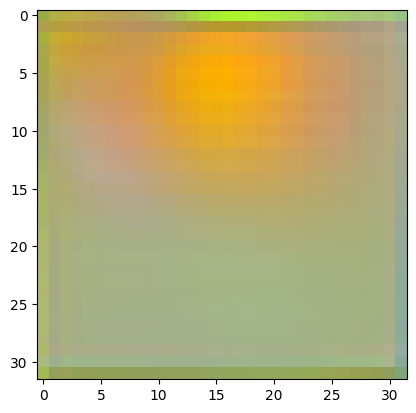

(-0.540448863537517, 8.381168880756874)


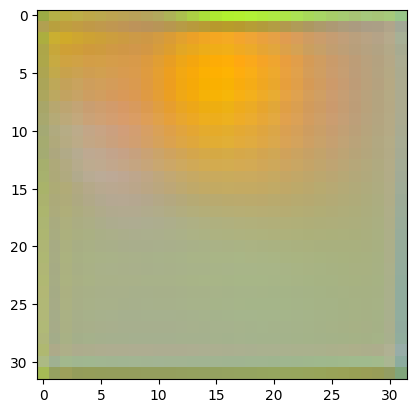

(-0.52761146085875, 8.670411506892076)


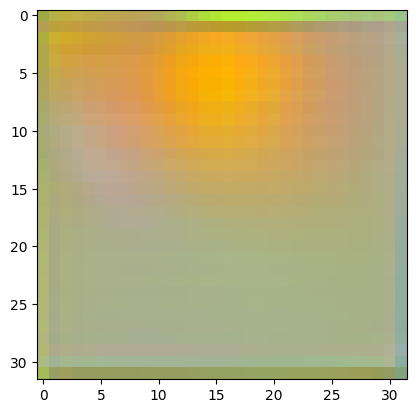

(-0.5252446786405752, 8.750211333250569)


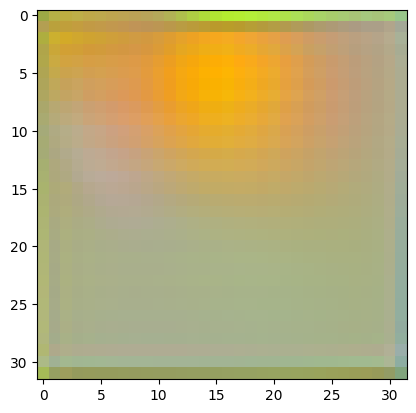

2it [01:10, 35.35s/it]


Number of function evaluations: 194
(0.005601930871686515, 1.0142150198016076)


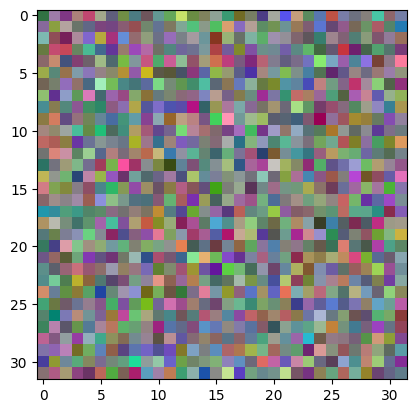

(-0.00848552788076896, 0.7016687506256559)


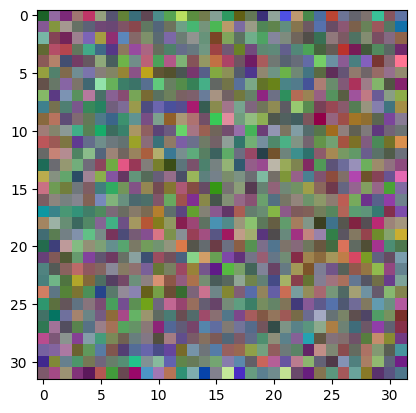

(-0.0217470940381853, 0.4883535790342416)


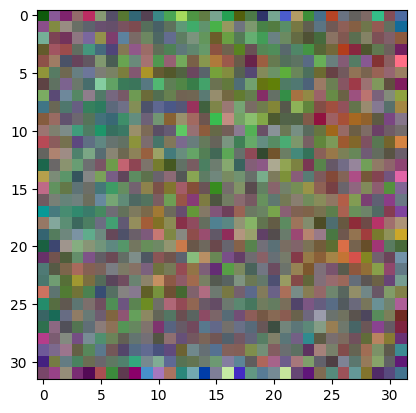

(-0.032826520624885454, 0.38457373880037116)


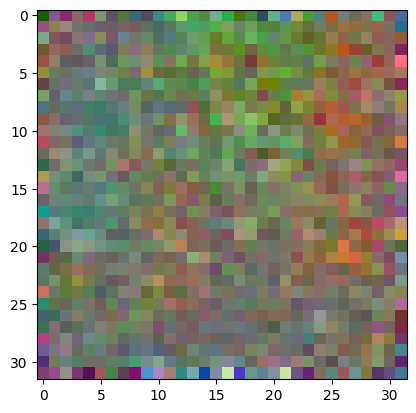

(-0.043404960325454635, 0.35480708662544497)


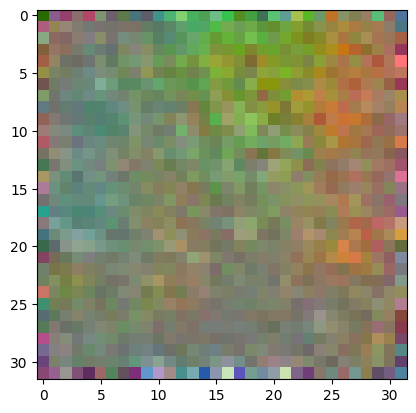

(-0.052561337869838555, 0.3720516676442567)


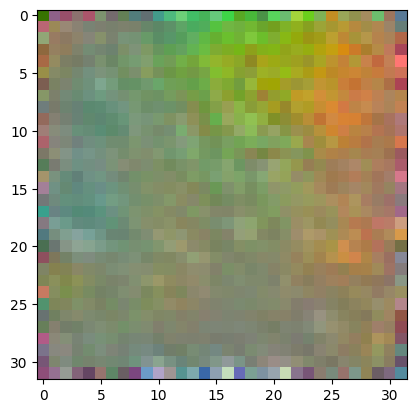

(-0.061739313928907864, 0.4142023828589868)


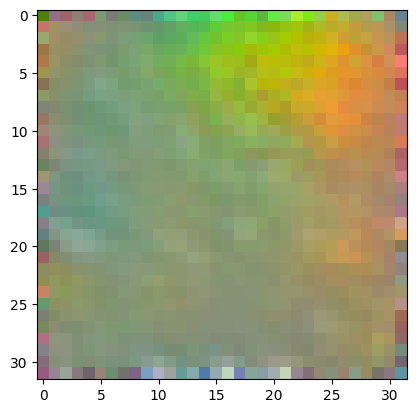

(-0.07185777524254536, 0.47686211893141944)


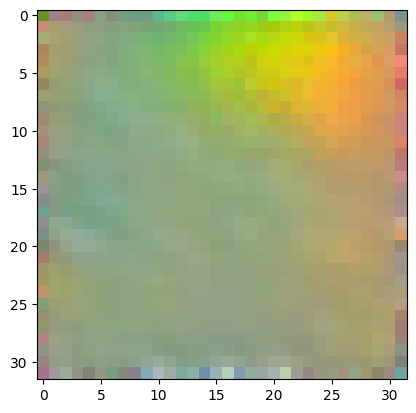

(-0.08315184517474061, 0.5539856721722876)


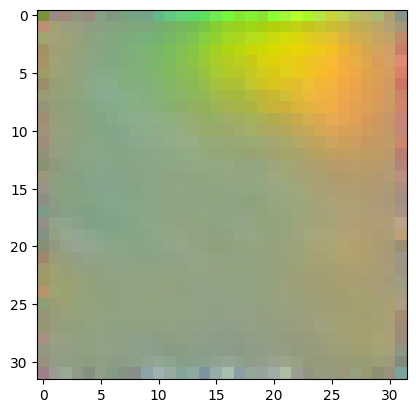

(-0.09779204878713106, 0.6531369386332259)


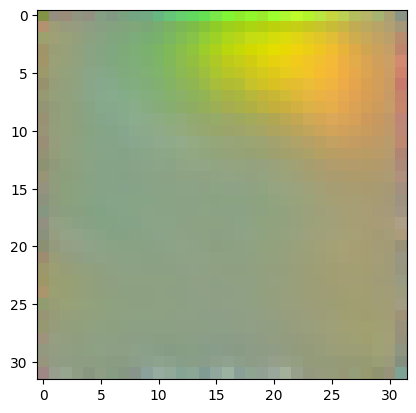

(-0.11926568746215453, 0.7887601447034003)


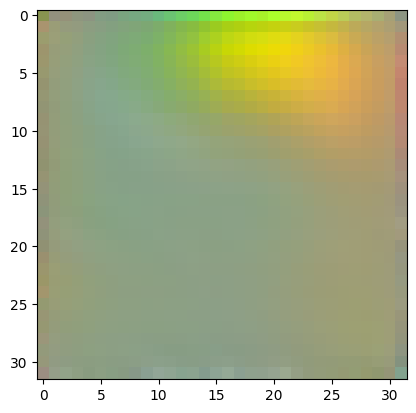

(-0.14870630236691995, 0.955380592744276)


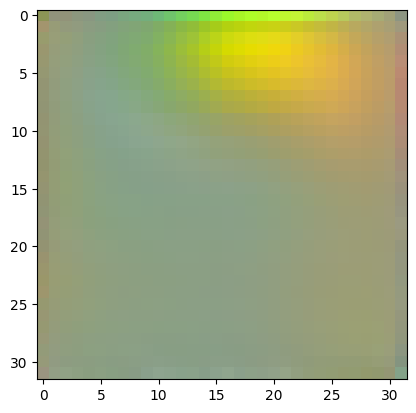

(-0.1867791154053414, 1.1458116759990085)


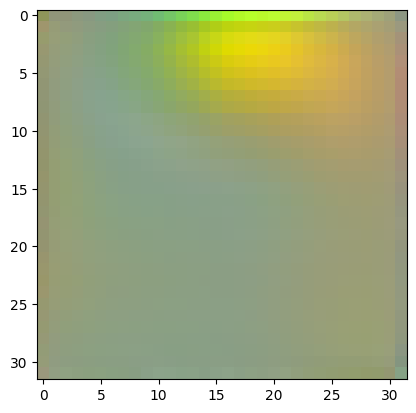

(-0.23473009384978796, 1.359050641580459)


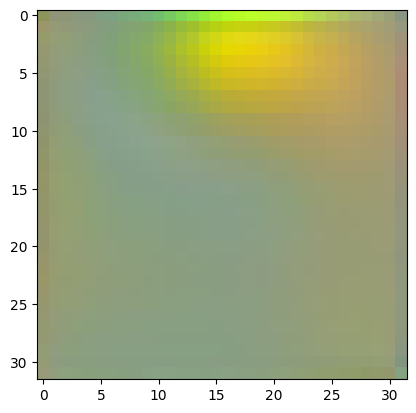

(-0.29361466975557776, 1.5962856771392713)


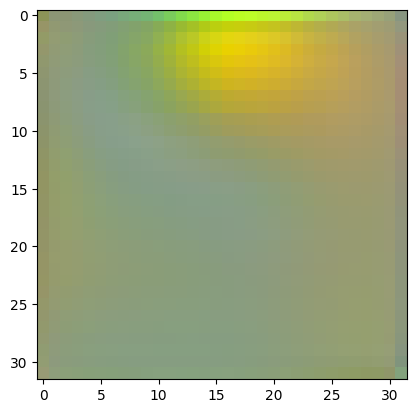

(-0.3647509834930502, 1.864649214729841)


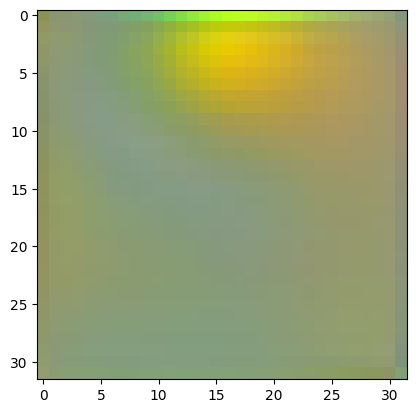

(-0.4495389387837739, 2.1800638712990676)


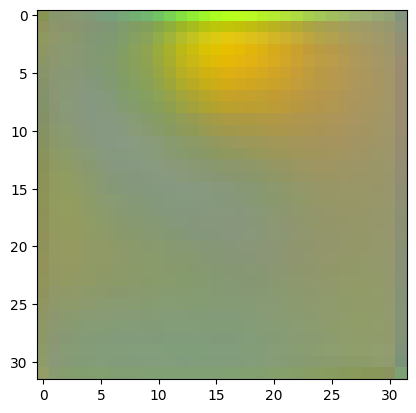

(-0.5477993546012241, 2.5686024390272633)


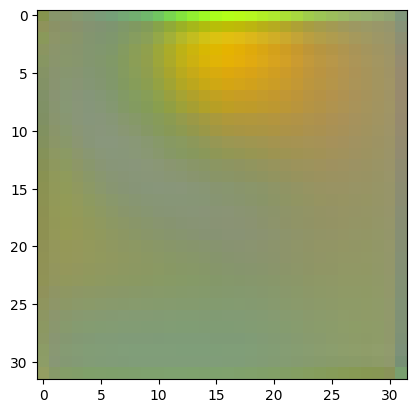

(-0.6511799553011781, 3.0612449933279886)


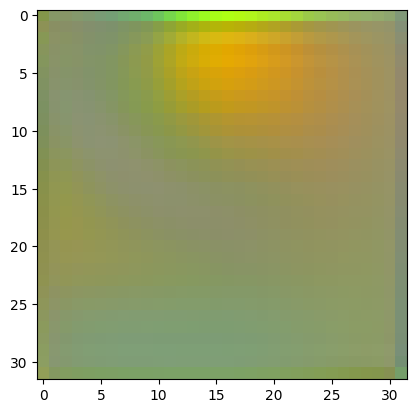

(-0.7310695685104472, 3.669864434181073)


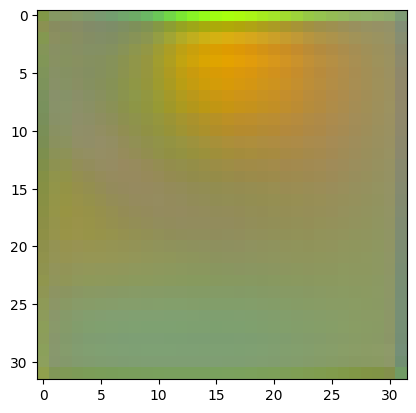

(-0.7570867658125189, 4.409675077405837)


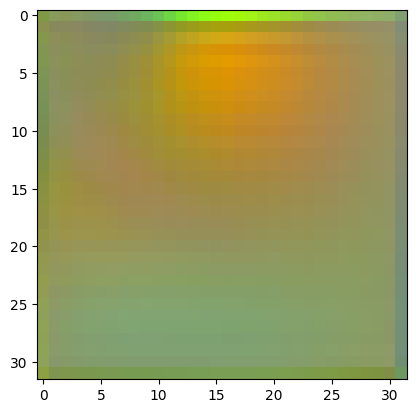

(-0.7371045473860175, 5.0513304281280105)


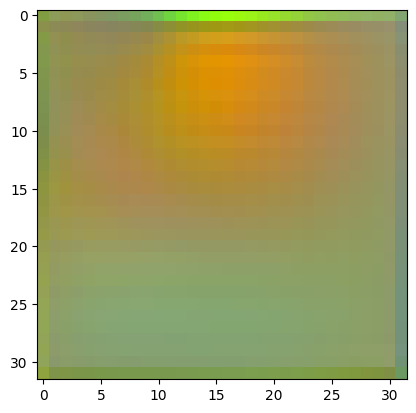

(-0.693407078714896, 5.716755952065389)


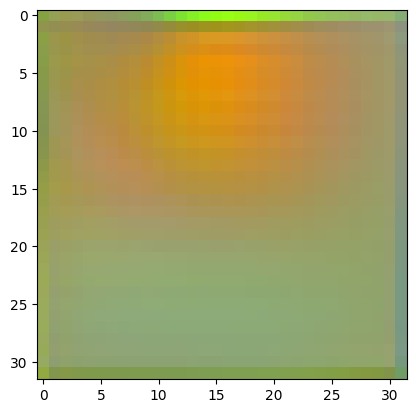

(-0.6381556894669197, 6.411515968235568)


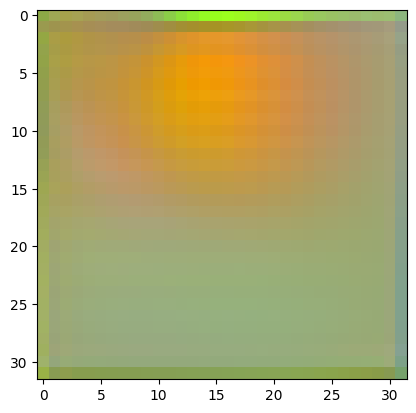

(-0.5905852101380301, 7.033331272394312)


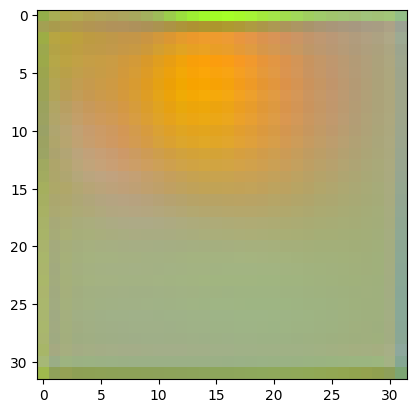

(-0.5478377636314828, 7.661912685944982)


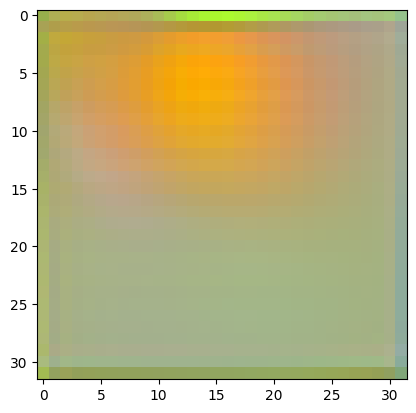

(-0.511720322487584, 8.309504335680941)


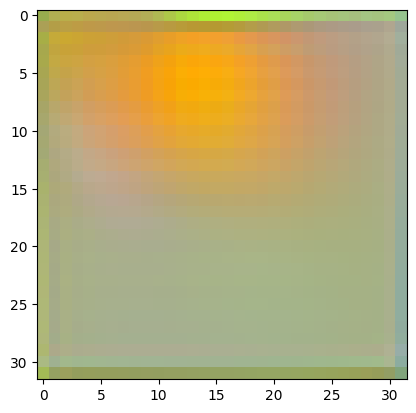

(-0.48680621059494794, 8.881276483153622)


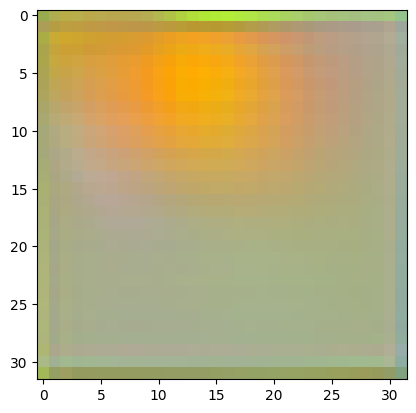

(-0.4771735673912942, 9.151364605250956)


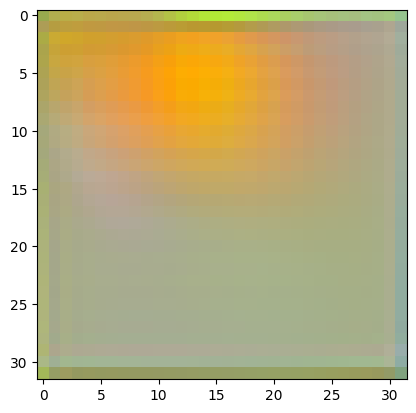

(-0.47532513741826765, 9.210403136991735)


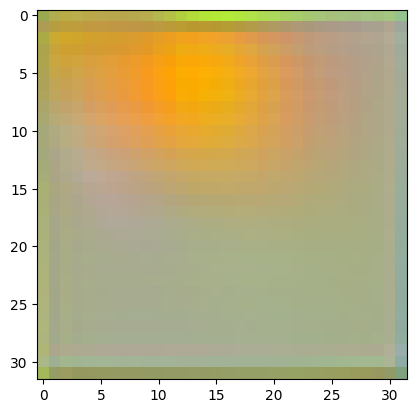

3it [01:46, 35.46s/it]


In [15]:
#@title Sampling image
samples = []

model_score = Model()
file = f'model_cifar.pth'
ckpt = torch.load(file)
model_score.load_state_dict(ckpt)
model_score.eval();

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  diffuse_sample(data[None], samples, diffusion_coeff_fn, marginal_prob_std_fn, model_score, idx)
  # samples = np.concatenate(samples, axis = 1)
  for i in range(samples[idx].shape[0]):
    print(f'{samples[idx][i].mean(), samples[idx][i].std()}')
    plt.imshow(((samples[idx][i] - samples[idx][i].min())/(samples[idx][i].max() - samples[idx][i].min())).transpose(1, 2, 0))
    plt.show()